In [1]:
import numpy as np
import pandas as pd
import pandas_ta
# import ta
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

%config InlineBackend.figure_format = 'retina'

# Download data

In [2]:
symbols_list = ['AAPL', 'NVDA', 'TXG', 'TLSA', 'META', 'AMD', 'MSFT', 'GOOGL', 'TSM']

In [3]:
# end_date = '2024-08-02'
end_date = dt.datetime.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*12)

In [4]:
df = yf.download(symbols_list,
                 start=start_date,
                 end=end_date, threads=True).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.columns.name = None

[*********************100%%**********************]  9 of 9 completed


# Add technical indicators

In [5]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(x, window=14))

df['bb_low'] = df.groupby(level=1, group_keys=False)['adj close'].apply(lambda x: pandas_ta.bbands(np.log1p(x), length=14)).iloc[:,0]
df['bb_mid'] = df.groupby(level=1, group_keys=False)['adj close'].apply(lambda x: pandas_ta.bbands(np.log1p(x), length=14)).iloc[:,1]
df['bb_high'] = df.groupby(level=1, group_keys=False)['adj close'].apply(lambda x: pandas_ta.bbands(np.log1p(x), length=14)).iloc[:,2]

def compute_atr(data):
    atr = pandas_ta.atr(high=data['high'],
                        low=data['low'],
                        close=data['adj close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=14)
    # macd = macd.iloc[:,0]
    return macd
    # return macd.sub(macd.mean()).div(macd.std())

# df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd).iloc[:,0].groupby(level=1).transform(lambda x: x.sub(x.mean()).div(x.std()))
df['dollar_volume'] = df['adj close'] * df['volume']/1e6

In [6]:
df['long'] = (df['rsi'] < 30).astype(int)
df['short'] = (df['rsi'] > 70).astype(int)

In [7]:
df.groupby(level=1, group_keys=False).long.sum(), df.groupby(level=1, group_keys=False).short.sum()

(ticker
 AAPL      65
 AMD       90
 GOOGL     32
 META      59
 MSFT      20
 NVDA      43
 TLSA      29
 TSM       60
 TXG      104
 Name: long, dtype: int64,
 ticker
 AAPL     408
 AMD      279
 GOOGL    283
 META     280
 MSFT     299
 NVDA     433
 TLSA      56
 TSM      245
 TXG       50
 Name: short, dtype: int64)

In [8]:
df.dropna().unstack()[['long']].resample('ME').sum().stack('ticker').iloc[-27:]

long
date       ticker      
2024-09-30 AAPL     0.0
           AMD      0.0
           GOOGL    3.0
           META     0.0
           MSFT     0.0
           NVDA     0.0
           TLSA     0.0
           TSM      0.0
           TXG      0.0
2024-10-31 AAPL     0.0
           AMD      0.0
           GOOGL    0.0
           META     0.0
           MSFT     0.0
           NVDA     0.0
           TLSA     0.0
           TSM      0.0
           TXG      2.0
2024-11-30 AAPL     0.0
           AMD      0.0
           GOOGL    0.0
           META     0.0
           MSFT     0.0
           NVDA     0.0
           TLSA     0.0
           TSM      0.0
           TXG      0.0

In [9]:
df.iloc[-20:,7]

date        ticker
2024-11-07  TSM       59.385453
            TXG       42.622750
2024-11-08  AAPL      48.841933
            AMD       44.821484
            GOOGL     66.784282
            META      58.071789
            MSFT      51.950942
            NVDA      65.378228
            TLSA      47.930463
            TSM       59.393366
            TXG       39.574062
2024-11-11  AAPL      44.132834
            AMD       43.818589
            GOOGL     68.046156
            META      53.957240
            MSFT      53.409026
            NVDA      64.995018
            TLSA      45.647165
            TSM       53.075582
            TXG       42.339554
Name: rsi, dtype: float64

In [10]:
df.iloc[-20:,-2]

date        ticker
2024-11-07  TSM       0
            TXG       0
2024-11-08  AAPL      0
            AMD       0
            GOOGL     0
            META      0
            MSFT      0
            NVDA      0
            TLSA      0
            TSM       0
            TXG       0
2024-11-11  AAPL      0
            AMD       0
            GOOGL     0
            META      0
            MSFT      0
            NVDA      0
            TLSA      0
            TSM       0
            TXG       0
Name: long, dtype: int64

In [11]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
def opt_weight(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252, log_returns=False)
    
    cov = risk_models.sample_cov(prices=prices, frequency=252, log_returns=False)
    
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(min(lower_bound, 0.1),max(lower_bound, 0.1)), solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [12]:
optim_df = df.unstack().resample('M')['adj close'].last()
optim_df.index = optim_df.index + pd.DateOffset(1)

In [13]:
optim_start_date = (pd.to_datetime(end_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
optim_end_date = (pd.to_datetime(end_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
prices = df.unstack()['adj close'][optim_start_date:optim_end_date].dropna()

In [14]:
weights = pd.DataFrame(opt_weight(prices, round(1/len(symbols_list)*2,3)), index=[0])

In [15]:
weights

,AAPL,AMD,GOOGL,META,MSFT,NVDA,TLSA,TSM,TXG
0,0.1,0.1,0.1,0.1,0.1,0.20002,0.09999,0.1,0.1


In [16]:
new_df = np.log(df.unstack()['adj close'][start_date:end_date]).diff().dropna()
new_df.columns.names = [None]
tmp_df = new_df.copy()
tmp_df = tmp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                left_index=True, right_index=True).reset_index().set_index(['date','index']).unstack().stack()
tmp_df.index.names = ['date','ticker']
tmp_df['weighted_return'] = tmp_df['return']*tmp_df['weight']
tmp_df = tmp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
portfolio_df = tmp_df.copy()

In [17]:
spy = yf.download(tickers='SPY', start='2015-01-01', end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


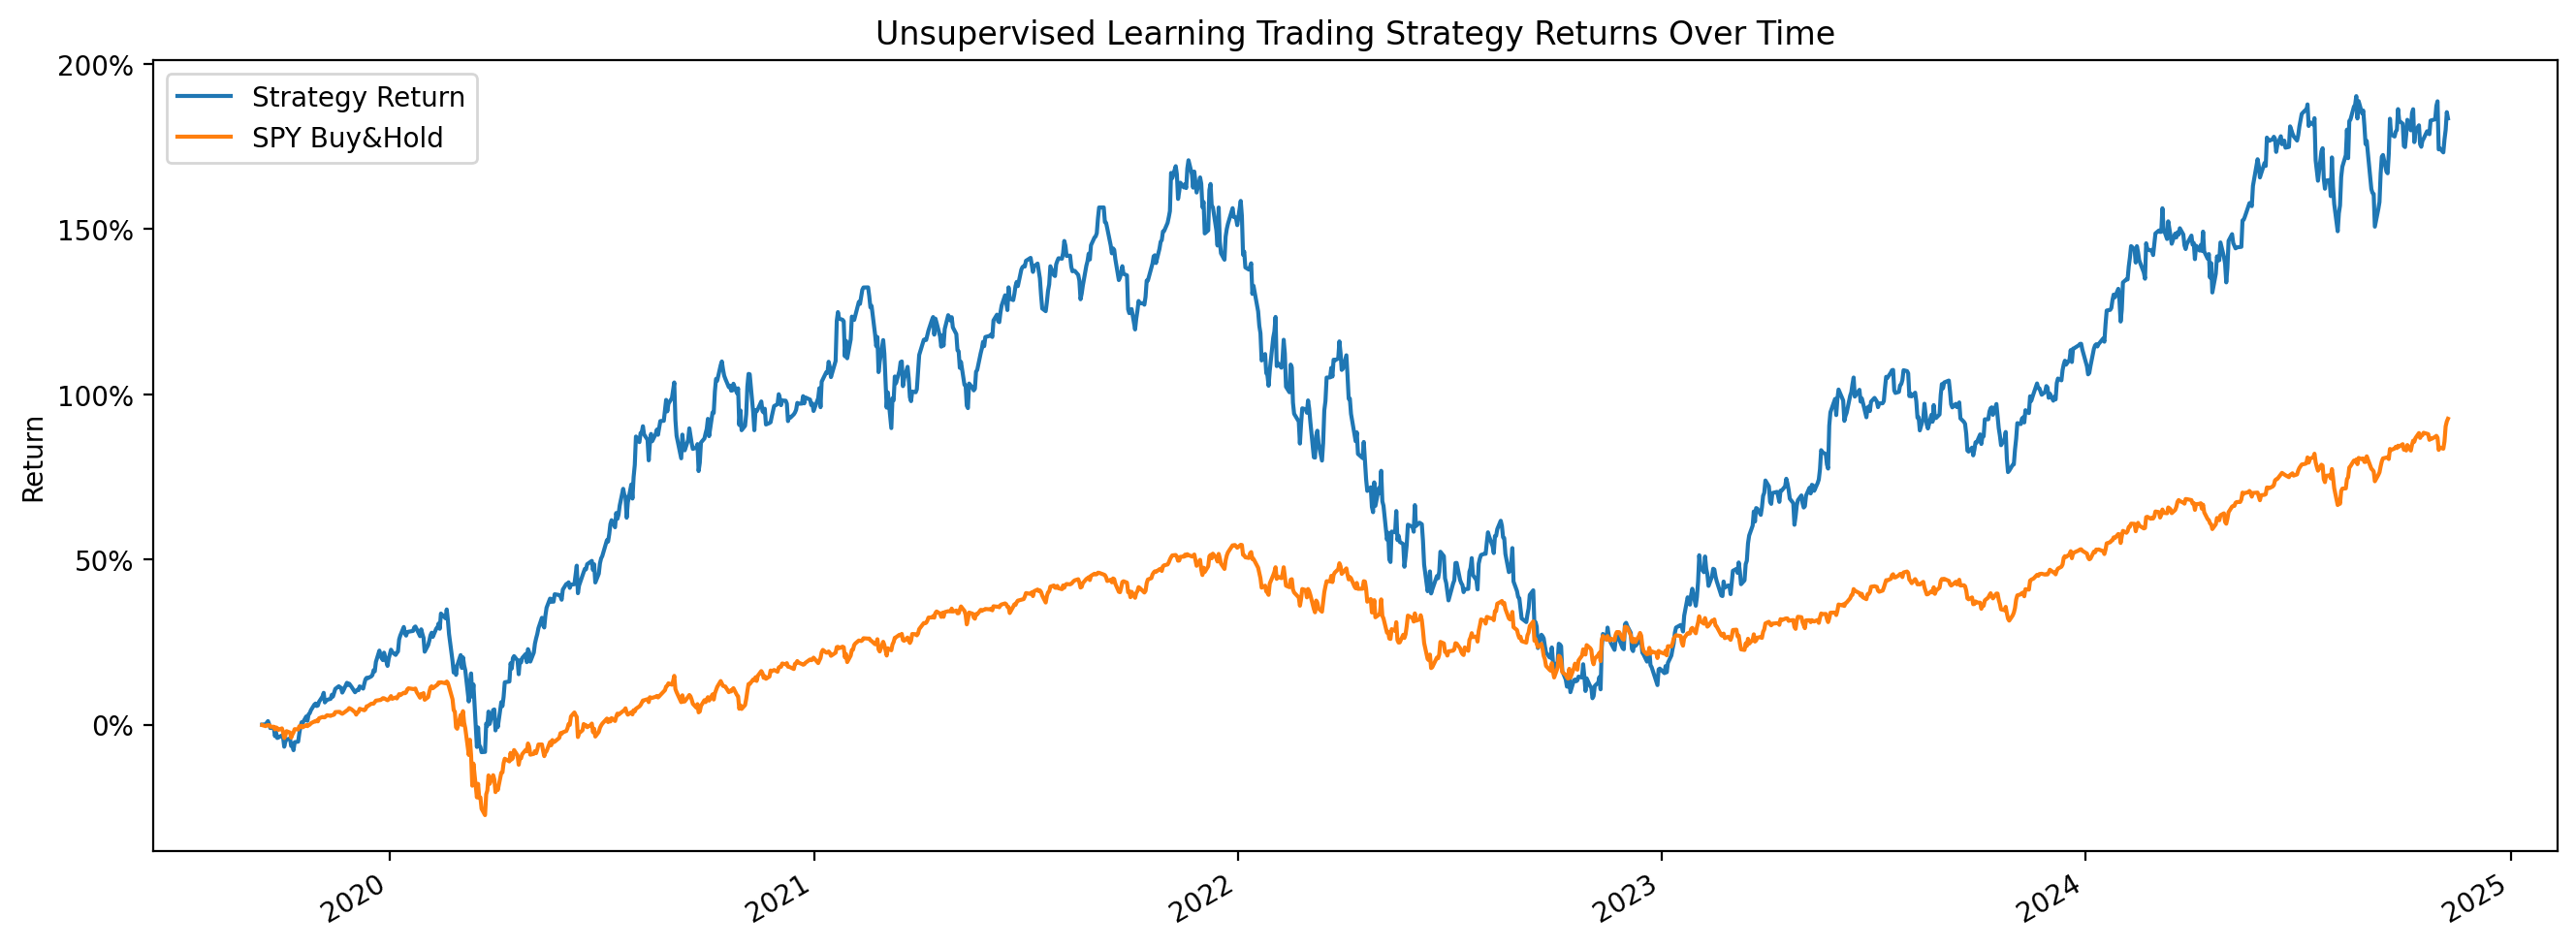

In [18]:
import matplotlib.ticker as mtick

portfolio_cumulative_ret = np.exp(np.log1p(portfolio_df).cumsum()) - 1 
portfolio_cumulative_ret.plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

<Axes: >

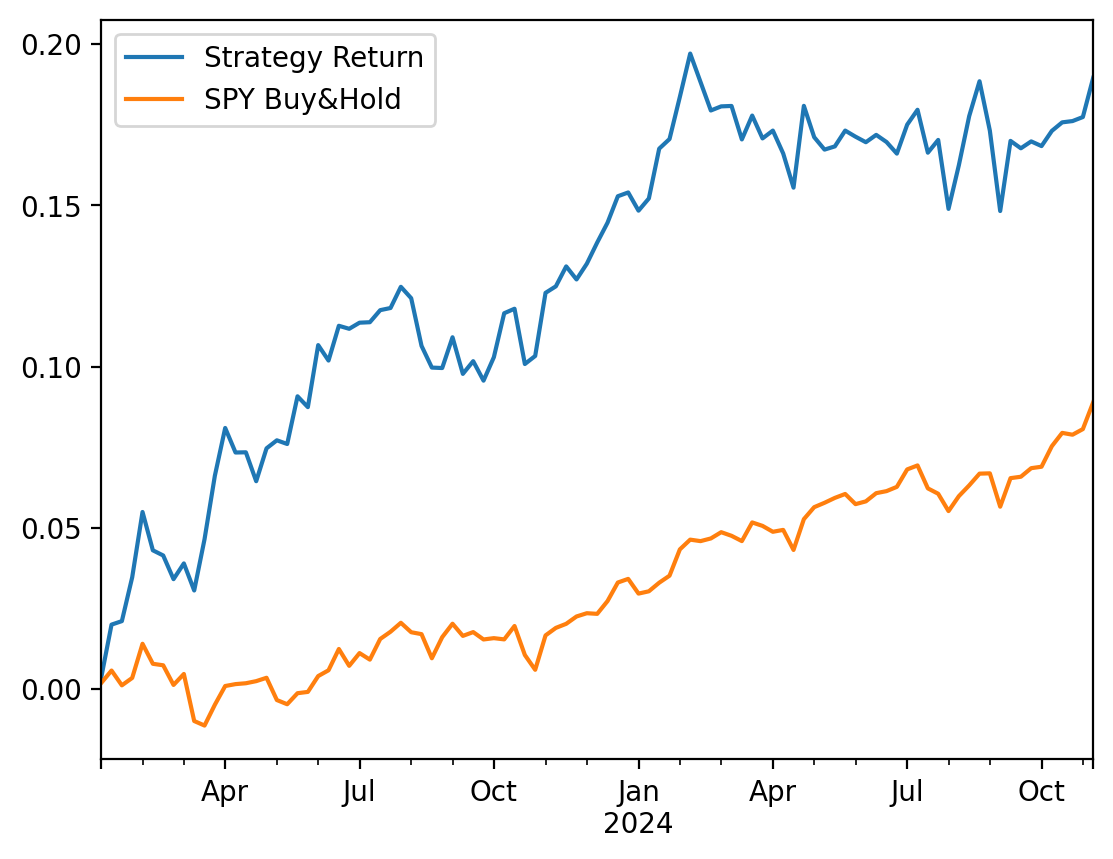

In [19]:
(np.exp(np.log1p(portfolio_df['2023-01-01':].resample('W').median()).cumsum()) - 1).plot()

In [20]:
from scipy.optimize import minimize

def custom_nonconvex_objective(weights, returns, covariance_matrix):
    # A custom objective could involve nonlinear combinations
    portfolio_return = weights @ returns
    portfolio_variance = weights @ covariance_matrix @ weights.T
    
    # Example: maximize returns, penalize high variance (non-convex function)
    return -portfolio_return + 0.5 * (portfolio_variance ** 2) 

# Define constraints (e.g., sum of weights = 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

returns = expected_returns.mean_historical_return(prices=prices, frequency=252, log_returns=True)
cov = risk_models.sample_cov(prices=prices, frequency=252, log_returns=True)

# Optimize with custom objective
result = minimize(custom_nonconvex_objective, x0=np.ones(len(returns))/len(returns), 
                  args=(returns, cov), 
                  method='SLSQP', bounds=[(0.1, round(1/len(symbols_list)*2,3))]*len(returns), 
                  constraints=constraints)

optimized_weights = result.x

In [21]:
optimized_weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1])

In [22]:
def compound_interest_cal_w_m(p:float, r:float, c:float, n:float, monthly_addition:float) -> float:
    """Calculate compound interest with monthly addition

    Args:
        p (flot): The principal amount.
        r (flot): The annual interest rate.
        c (flot): The number of compounding periods per year.
        n (flot): The number of years.
        monthly_addition (flot): The monthly contribution.

    Returns:
        flot: The future value of the investment.
    """
    term1 = p * (1 + r/c) ** (c*n)
    term2 = (monthly_addition * ((1 + r/c) ** (c*n) - 1)) / (r/c)
    return term1 + term2

In [23]:
apy = (np.exp(np.log1p(portfolio_df).cumsum()) - 1)['Strategy Return'][-1]/((portfolio_df.index[-1] - portfolio_df.index[0]) / pd.Timedelta(days=365))
compound_interest_cal_w_m(3000, apy, 1, 8, 170)

39215.147607520004

In [24]:
apy

0.35573530447599605

<Axes: >

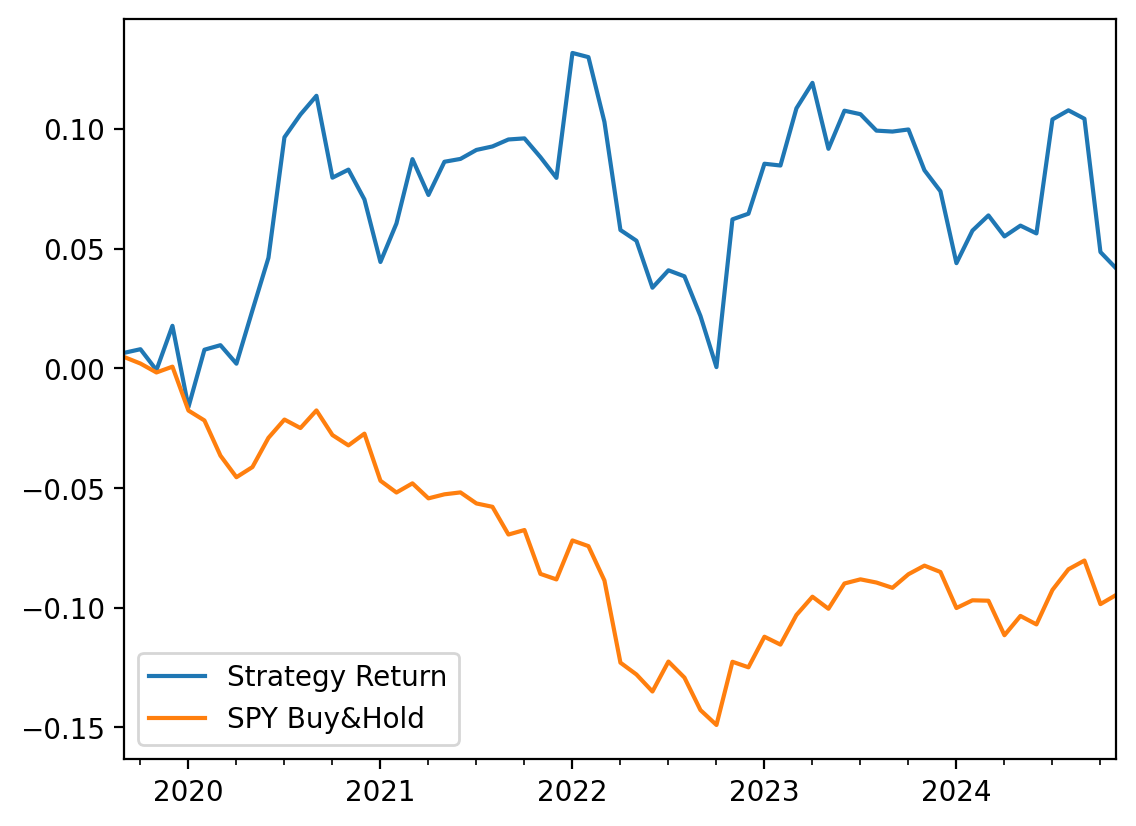

In [25]:
(np.exp(np.log1p(portfolio_df.resample('M').last()).cumsum()) - 1).plot()